Use data from Kaggle to model the outcome of certain pairings between teams, given their rank, points, and the weighted point difference with the opponent.
# Data I/O

- [FIFA rankings from 1993 to 2018 (courtesy of Tadhg Fitzgerald](https://www.kaggle.com/tadhgfitzgerald/fifa-international-soccer-mens-ranking-1993now))
    - This one I used to get the FIFA ranking and points for the teams, which is a monthly changing rank previously shown as a [decent predictor](http://www.sportingintelligence.com/2014/06/20/upsets-giant-killings-adios-bye-bye-fifa-rankings-still-ahead-in-predicting-results-200601/) of team performance
- [International Soccer matches from 1872 to 2018 (courtesy of Mart Jürisoo](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017))
    - This I will use to find out how much the difference in point, ranks and the current rank of the team affects the outocme of a match
- [FIFA World Cup 2018 data set (courtesy of Nuggs](https://www.kaggle.com/ahmedelnaggar/fifa-worldcup-2018-dataset))

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',100)
from matplotlib import pyplot as plt

rankings = pd.read_csv('data/fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('data/results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

world_cup = pd.read_csv('data/World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

# Feature extraction

I join the matches with the ranks of the different teams. Then extract some features:
- point and rank differences
- if the game was for some stakes, because my naive view was that typically friendly matches are harder to predict (TODO differentiate the WC matches from the rest)

In [2]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [3]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

# # how many days the different teams were able to rest but this turned out to be not important enough to be worth the hassle
# max_rest = 30
# matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# # include the participant countries as a one hot vector but that did not appear to be a strong predictor either
# matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
# matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
# matches = matches.join(pd.get_dummies(matches['wc_participant']))

In [4]:
matches.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,country_abrv_home,cur_year_avg_weighted_home,two_year_ago_weighted_home,three_year_ago_weighted_home,weighted_points_home,rank_date_away,rank_away,country_full_away,country_abrv_away,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away,rank_difference,average_rank,point_difference,score_difference,is_won,is_stake
18474,2018-06-07,Uruguay,Uzbekistan,3,0,Friendly,Montevideo,Uruguay,False,2018-06-07,14.0,Uruguay,URU,486.28,168.44,119.85,774.57,2018-06-07,95.0,Uzbekistan,UZB,66.85,93.52,40.74,201.11,-81.0,54.5,573.46,3,True,False
18475,2018-06-07,Portugal,Algeria,3,0,Friendly,Lisbon,Portugal,False,2018-06-07,4.0,Portugal,POR,646.92,155.33,125.53,927.78,2018-06-07,66.0,Algeria,ALG,163.41,91.40,101.63,356.44,-62.0,35.0,571.34,3,True,False
18476,2018-06-07,Korea Republic,Bolivia,0,0,Friendly,Innsbruck,Austria,True,2018-06-07,57.0,Korea Republic,KOR,162.13,91.79,65.96,319.88,2018-06-07,59.0,Bolivia,BOL,291.14,66.68,21.32,379.14,-2.0,58.0,-59.26,0,False,False
18477,2018-06-07,Iceland,Ghana,2,2,Friendly,Reykjavík,Iceland,False,2018-06-07,22.0,Iceland,ISL,438.64,90.61,96.64,625.89,2018-06-07,47.0,Ghana,GHA,261.21,99.90,92.63,453.74,-25.0,34.5,172.15,0,False,False
18478,2018-06-07,India,New Zealand,1,2,Friendly,Mumbai,India,False,2018-06-07,97.0,India,IND,196.24,25.50,17.00,238.74,2018-06-07,120.0,New Zealand,NZL,78.58,76.45,3.81,158.84,-23.0,108.5,79.90,-1,False,False


# Modeling

In [18]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won'].astype(int)
# X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches.loc[:,['home_score', 'away_score']].values
# X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['home_score']
# X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['score_difference']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
# max_depth = 30
# regr_rf = RandomForestRegressor(n_estimators=10, max_depth=max_depth, random_state=2)
logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
#     ('random_forest_regression', regr_rf)
])
model = model.fit(X_train, y_train)

## XGB

In [7]:
# import xgboost as xgb
# from sklearn import metrics

# denom = 0
# fold = 5 #Change to 5, 1 for Kaggle Limits
# for i in range(fold):
#     params = {
#         'eta': 0.03333,
#         'max_depth': 4,
# #         'objective': 'multi:softprob',
#         'eval_metric': 'mlogloss',
# #         'num_class': 9,
#         'num_class': 2,
#         'seed': i,
#         'silent': True,
# #         'tree_method': 'gpu_hist'
#     }
# #     x1, x2, y1, y2 = model_selection.train_test_split(train, y, test_size=0.18, random_state=i)
#     x1, x2, y1, y2 = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
#     watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
#     model = xgb.train(params, xgb.DMatrix(x1, y1), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)
# #     score1 = metrics.log_loss(y2, model.predict(xgb.DMatrix(x2), ntree_limit=model.best_ntree_limit), labels = list(range(9)))
# #     score1 = metrics.log_loss(y2, model.predict(xgb.DMatrix(x2), ntree_limit=model.best_ntree_limit))
# #     print(score1)
#     #if score < 0.9:
#     if denom != 0:
# #         pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
#         pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit+80)
#         preds += pred
#     else:
# #         pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
#         pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit+80)
#         preds = pred.copy()
#     denom += 1
# #     submission = pd.DataFrame(pred, columns=['class'+str(c+1) for c in range(9)])
#     submission = pd.DataFrame(pred, columns=['is_won'])
# #     submission['ID'] = pid
# #     submission.to_csv('submission_xgb_fold_'  + str(i) + '.csv', index=False)
# preds /= denom
# submission = pd.DataFrame(preds, columns=['is_won'])
# # submission['ID'] = pid
# # submission.to_csv('submission.gz', index=False, compression='gzip')

## Confusion Matrix

Confusion Matrix of Test Set
[[651 302]
 [297 598]]
Confusion Matrix of Training Set
[[5928 2649]
 [2715 5339]]


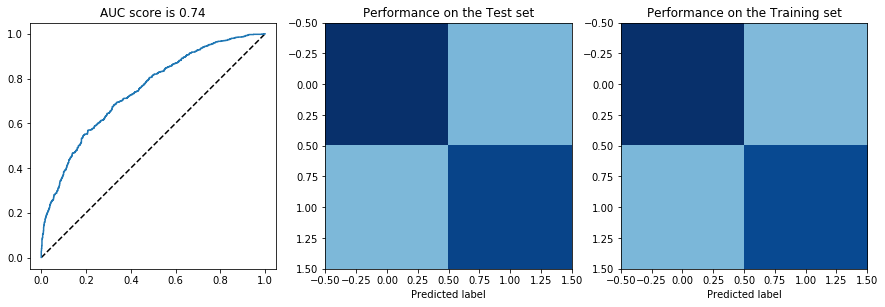

In [20]:
# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
print('Confusion Matrix of Test Set')
print(cm)
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
print('Confusion Matrix of Training Set')
print(cm)
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

Confusion matrix, without normalization
[[5928 2649]
 [2715 5339]]
Normalized confusion matrix
[[ 0.69  0.31]
 [ 0.34  0.66]]


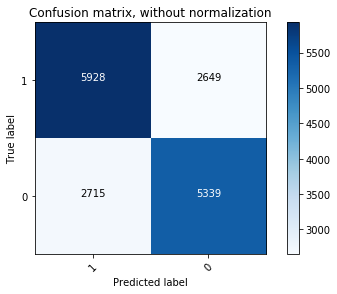

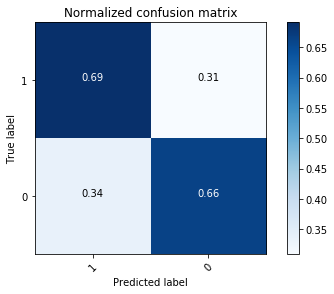

In [28]:
# print(__doc__)

import itertools
# import numpy as np
# import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# # import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
# class_names = iris.target_names
class_names = y.unique().tolist()

# # Split the data into a training set and a test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# # Run classifier, using a model that is too regularized (C too low) to see
# # the impact on the results
# classifier = svm.SVC(kernel='linear', C=0.01)
# y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix = confusion_matrix(y_train, model.predict(X_train))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

I consider this pretty good performance, minding that soccer matches have typically only few goals scored and therefore making their outcome even more unpredictable. Nevertheless, let's look at the bad predictions and see where we are making mistakes more often.

Stakes distribution in the wrong predictions
True     0.592654
False    0.407346
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.615618
False    0.384382
Name: is_stake, dtype: float64


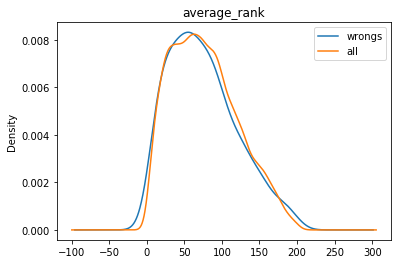

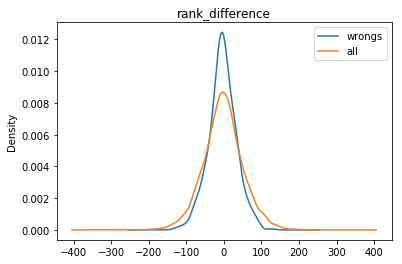

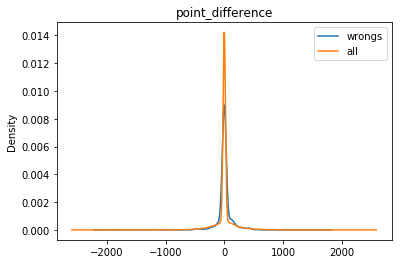

In [9]:
features = ['average_rank', 'rank_difference', 'point_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

From these figures, we read 
- we predict worse for closer ranks
- lower ranks in general
- and somewhat for matches with no stakes (Friendly here)

Luckily, this implies that for the world cup our predicitons may be somewhat even better

# World Cup simulation

## Group rounds

In [10]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [11]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group E:___
Brazil vs. Switzerland: Draw
Brazil vs. Costa Rica: Brazil wins with 0.61
Brazil vs. Serbia: Brazil wins with 0.66
Switzerland vs. Costa Rica: Switzerland wins with 0.59
Switzerland vs. Serbia: Switzerland wins with 0.64
Costa Rica vs. Serbia: Draw
___Starting group H:___
Poland vs. Senegal: Poland wins with 0.60
Poland vs. Colombia: Draw
Poland vs. Japan: Poland wins with 0.73
Senegal vs. Colombia: Colombia wins with 0.58
Senegal vs. Japan: Senegal wins with 0.65
Colombia vs. Japan: Colombia wins with 0.70
___Starting group F:___
Germany vs. Mexico: Germany wins with 0.58
Germany vs. Sweden: Germany wins with 0.61
Germany vs. Korea Republic: Germany wins with 0.67
Mexico vs. Sweden: Draw
Mexico vs. Korea Republic: Mexico wins with 0.68
Sweden vs. Korea Republic: Sweden wins with 0.64
___Starting group A:___
Russia vs. Saudi Arabia: Saudi Arabia wins with 0.55
Russia vs. Egypt: Egypt wins with 0.66
Russia vs. Uruguay: Uruguay wins with 0.82
Saudi Arabia vs. Egyp

## Single-elimination rounds

In [12]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
world_cup

,Team,Group,First match against,Second match against,Third match against,points,total_prob
0,Poland,H,Senegal,Colombia,Japan,7,1.865922
1,Colombia,H,Japan,Poland,Senegal,7,1.740535
2,Senegal,H,Poland,Japan,Colombia,3,1.466006
3,Japan,H,Colombia,Senegal,Poland,0,0.927536
4,Belgium,G,Panama,Tunisia,England,9,1.865864
5,England,G,Tunisia,Panama,Belgium,6,1.774826
6,Tunisia,G,England,Belgium,Panama,3,1.559950
7,Panama,G,Belgium,England,Tunisia,0,0.799360
8,Germany,F,Mexico,Sweden,Korea Republic,9,1.855877
9,Mexico,F,Germany,Korea Republic,Sweden,4,1.638425


In [13]:
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.54
Denmark vs. Croatia: Denmark wins with probability 0.54
Brazil vs. Mexico: Brazil wins with probability 0.57
Belgium vs. Colombia: Belgium wins with probability 0.57
Egypt vs. Portugal: Portugal wins with probability 0.81
France vs. Argentina: Argentina wins with probability 0.53
Switzerland vs. Germany: Germany wins with probability 0.60
England vs. Poland: Poland wins with probability 0.53


___Starting of the quarterfinal___
Spain vs. Denmark: Denmark wins with probability 0.51
Brazil vs. Belgium: Belgium wins with probability 0.51
Portugal vs. Argentina: Portugal wins with probability 0.51
Germany vs. Poland: Germany wins with probability 0.55


___Starting of the semifinal___
Denmark vs. Belgium: Belgium wins with probability 0.57
Portugal vs. Germany: Germany wins with probability 0.56


___Starting of the final___
Belgium vs. Germany: Germany wins with probability 0.54


